# In this workflow, we have tried to develop a predictive model based on Random Forest using Spatial Modeling Workflow with k-means clustering based spliting of data into train and test. we have changed target variables based on our need, for example, above-ground biomass (Bio_Dm) and biomass N uptake (Bio_N). also, we have changed predictor variables based on our study design. that is, including soil variables or excluding them.

# Import necessary packages

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skgstat import Variogram
import shap
import warnings
warnings.filterwarnings("ignore")
%matplotlib widget
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
import geopandas as gpd
import math
from scipy.stats import ks_2samp

# Load data: main dataset

In [14]:

# Load your cleaned data
df = pd.read_excel("D:/2nd_paper/Data_calculation/soil_biomass_all_year/model_lab_RS_data/DAT_IPP-N_TH.xlsx", sheet_name="Tabelle1")

#Encode categorical variable 'Crop'
df['Crop_encoded'] = df['Crop'].astype('category').cat.codes
# Drop missing values for relevant columns
predictor_columns = ['elev', 'aspect', 'slope', 
                     'Green-II', 'Red', 'Red-edge', 'NIR', 'NDVI', 'RDVI', 'RedEdge2', 
                     'GNDVI', 'NDRE', 'EVI2', 'Leaf chlorophyll index (LCI)', 'MSAVI2', 
                     'Red-Edge Chlorophyll Index (Cl)', 'Green Chlorophyll Index (Cl)', 
                     'MSR', 'MSR-RE', 'NIR/RE', 'NIR/R', 'Precipitation', 'Accumulated_PAR',
                     'Crop_encoded', 'BBCH', 'Days_Count']
target_column = "Bio_N"
df = df.dropna(subset=predictor_columns + [target_column, 'Crop', 'X', 'Y'])
df

,Patch,Crop,Crop_code,Sampling date,Date_Order,Sowing date,BBCH,year,Mp,Type,...,Red-Edge Chlorophyll Index (Cl),Green Chlorophyll Index (Cl),MSR,MSR-RE,NIR/RE,NIR/R,Precipitation,Accumulated_PAR,Days_Count,Crop_encoded
0,21,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,yq,...,2.664105,5.485714,2.584770,1.233579,3.664105,9.292398,361.2,30571.67,218,2
1,39,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,yq,...,2.859016,5.833091,2.600750,1.297007,3.859016,9.378486,361.2,30571.67,218,2
2,73,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,yq,...,2.551036,5.227456,2.392193,1.195808,3.551036,8.292115,361.2,30571.67,218,2
3,Ref1_Con,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,Ref_Con,...,2.393443,4.697248,2.067832,1.141880,3.393443,6.760498,361.2,30571.67,218,2
4,Ref1_Red,Rapeseed,1,2021-04-07,1.0,2020-09-01,50,1,NaN,Ref_Red,...,2.377778,5.071904,2.250581,1.136434,3.377778,7.600000,361.2,30571.67,218,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,51,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,yq,...,2.023501,4.314815,2.078621,1.008791,3.023501,6.808394,195.0,33697.00,82,4
571,102,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,yq,...,2.374711,4.604353,2.204173,1.135366,3.374711,7.381113,195.0,33697.00,82,4
572,114,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,yq,...,1.927936,3.769565,1.777768,0.972771,2.927936,5.549747,195.0,33697.00,82,4
573,Ref5_Con,Sunflower,5,2024-07-22,NaN,2024-05-02,64,4,NaN,Ref_Con,...,2.351574,4.445798,2.359502,1.127290,3.351574,8.129091,195.0,33697.00,82,4


# create spatial clusters with K-means: based on X and Y of the sampling locations

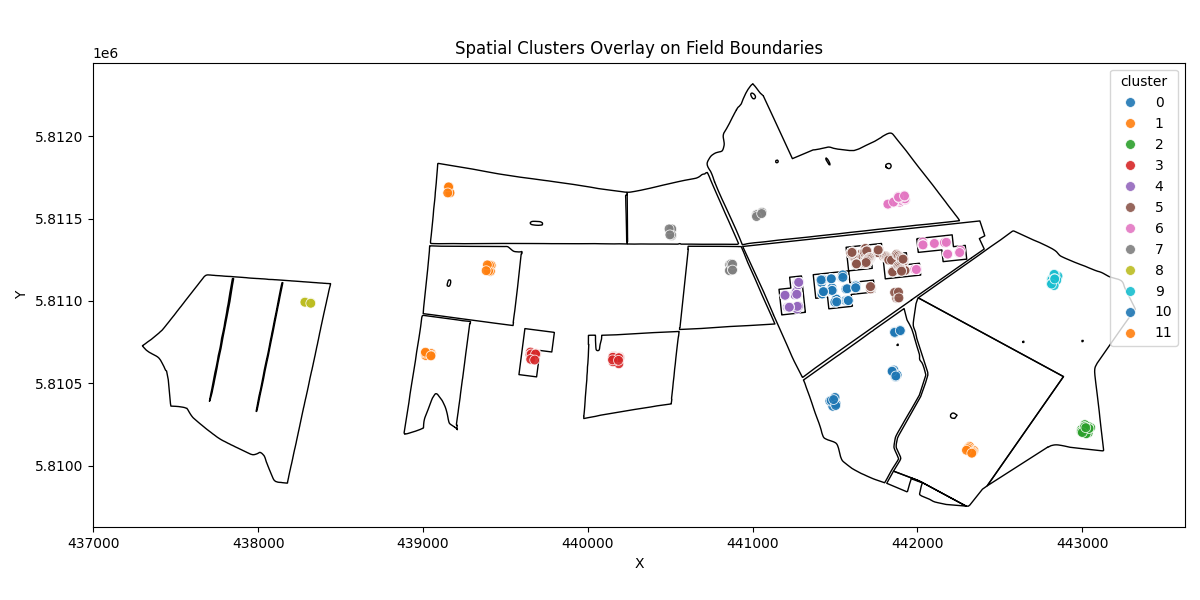

/n📍 Cluster distribution:
cluster
5     214
0      82
6      68
4      51
3      32
7      24
1      22
10     22
2      18
9      14
11     10
8       6
Name: count, dtype: int64


In [15]:
# Spatial Clustering with KMeans
kmeans = KMeans(n_clusters=12, random_state=50)
df['cluster'] = kmeans.fit_predict(df[['X', 'Y']])

# Visualize Clusters with Shapefile
shp_path = "D:/2nd_paper/GIS_RS_climate_data/shp_files/Tempelberg_all_fields/Tempelberg_fields_with_observations.shp"
gdf_fields = gpd.read_file(shp_path)

plt.figure(figsize=(12, 6))
gdf_fields.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
sns.scatterplot(data=df, x='X', y='Y', hue='cluster', palette='tab10', s=50, alpha=0.9)
plt.title("Spatial Clusters Overlay on Field Boundaries")
plt.grid(False)
plt.tight_layout()
plt.show()

print("/n📍 Cluster distribution:")
print(df['cluster'].value_counts())

# Selection of clusters as independent test/validation set: Here, we have visually inspect the clusters within the study area and selected clusters for test set, these clusters are as far as possible from the train clusters.

In [16]:
# Select Cluster(s) for Test Set
test_clusters = [1,2,3,4,7,8,9,11]
test_df = df[df['cluster'].isin(test_clusters)].copy()
train_df = df[~df['cluster'].isin(test_clusters)].copy()

print("/n🔹 Train samples by crop:")
print(train_df['Crop'].value_counts())
print("/n🔹 Test samples by crop:")
print(test_df['Crop'].value_counts())
print(test_clusters)
# Train/Test Split
X_train = train_df[predictor_columns]
y_train = train_df[target_column]
X_test = test_df[predictor_columns]
y_test = test_df[target_column]


/n🔹 Train samples by crop:
Crop
Maize        98
Rapeseed     68
Rye          68
Sunflower    54
Barley       52
Wheat        46
Name: count, dtype: int64
/n🔹 Test samples by crop:
Crop
Barley       40
Wheat        36
Rapeseed     33
Sunflower    28
Maize        26
Rye          14
Name: count, dtype: int64
[1, 2, 3, 4, 7, 8, 9, 11]


# Comparing Train vs Test Feature Distributions with KS Test, Histograms, and Boxplots

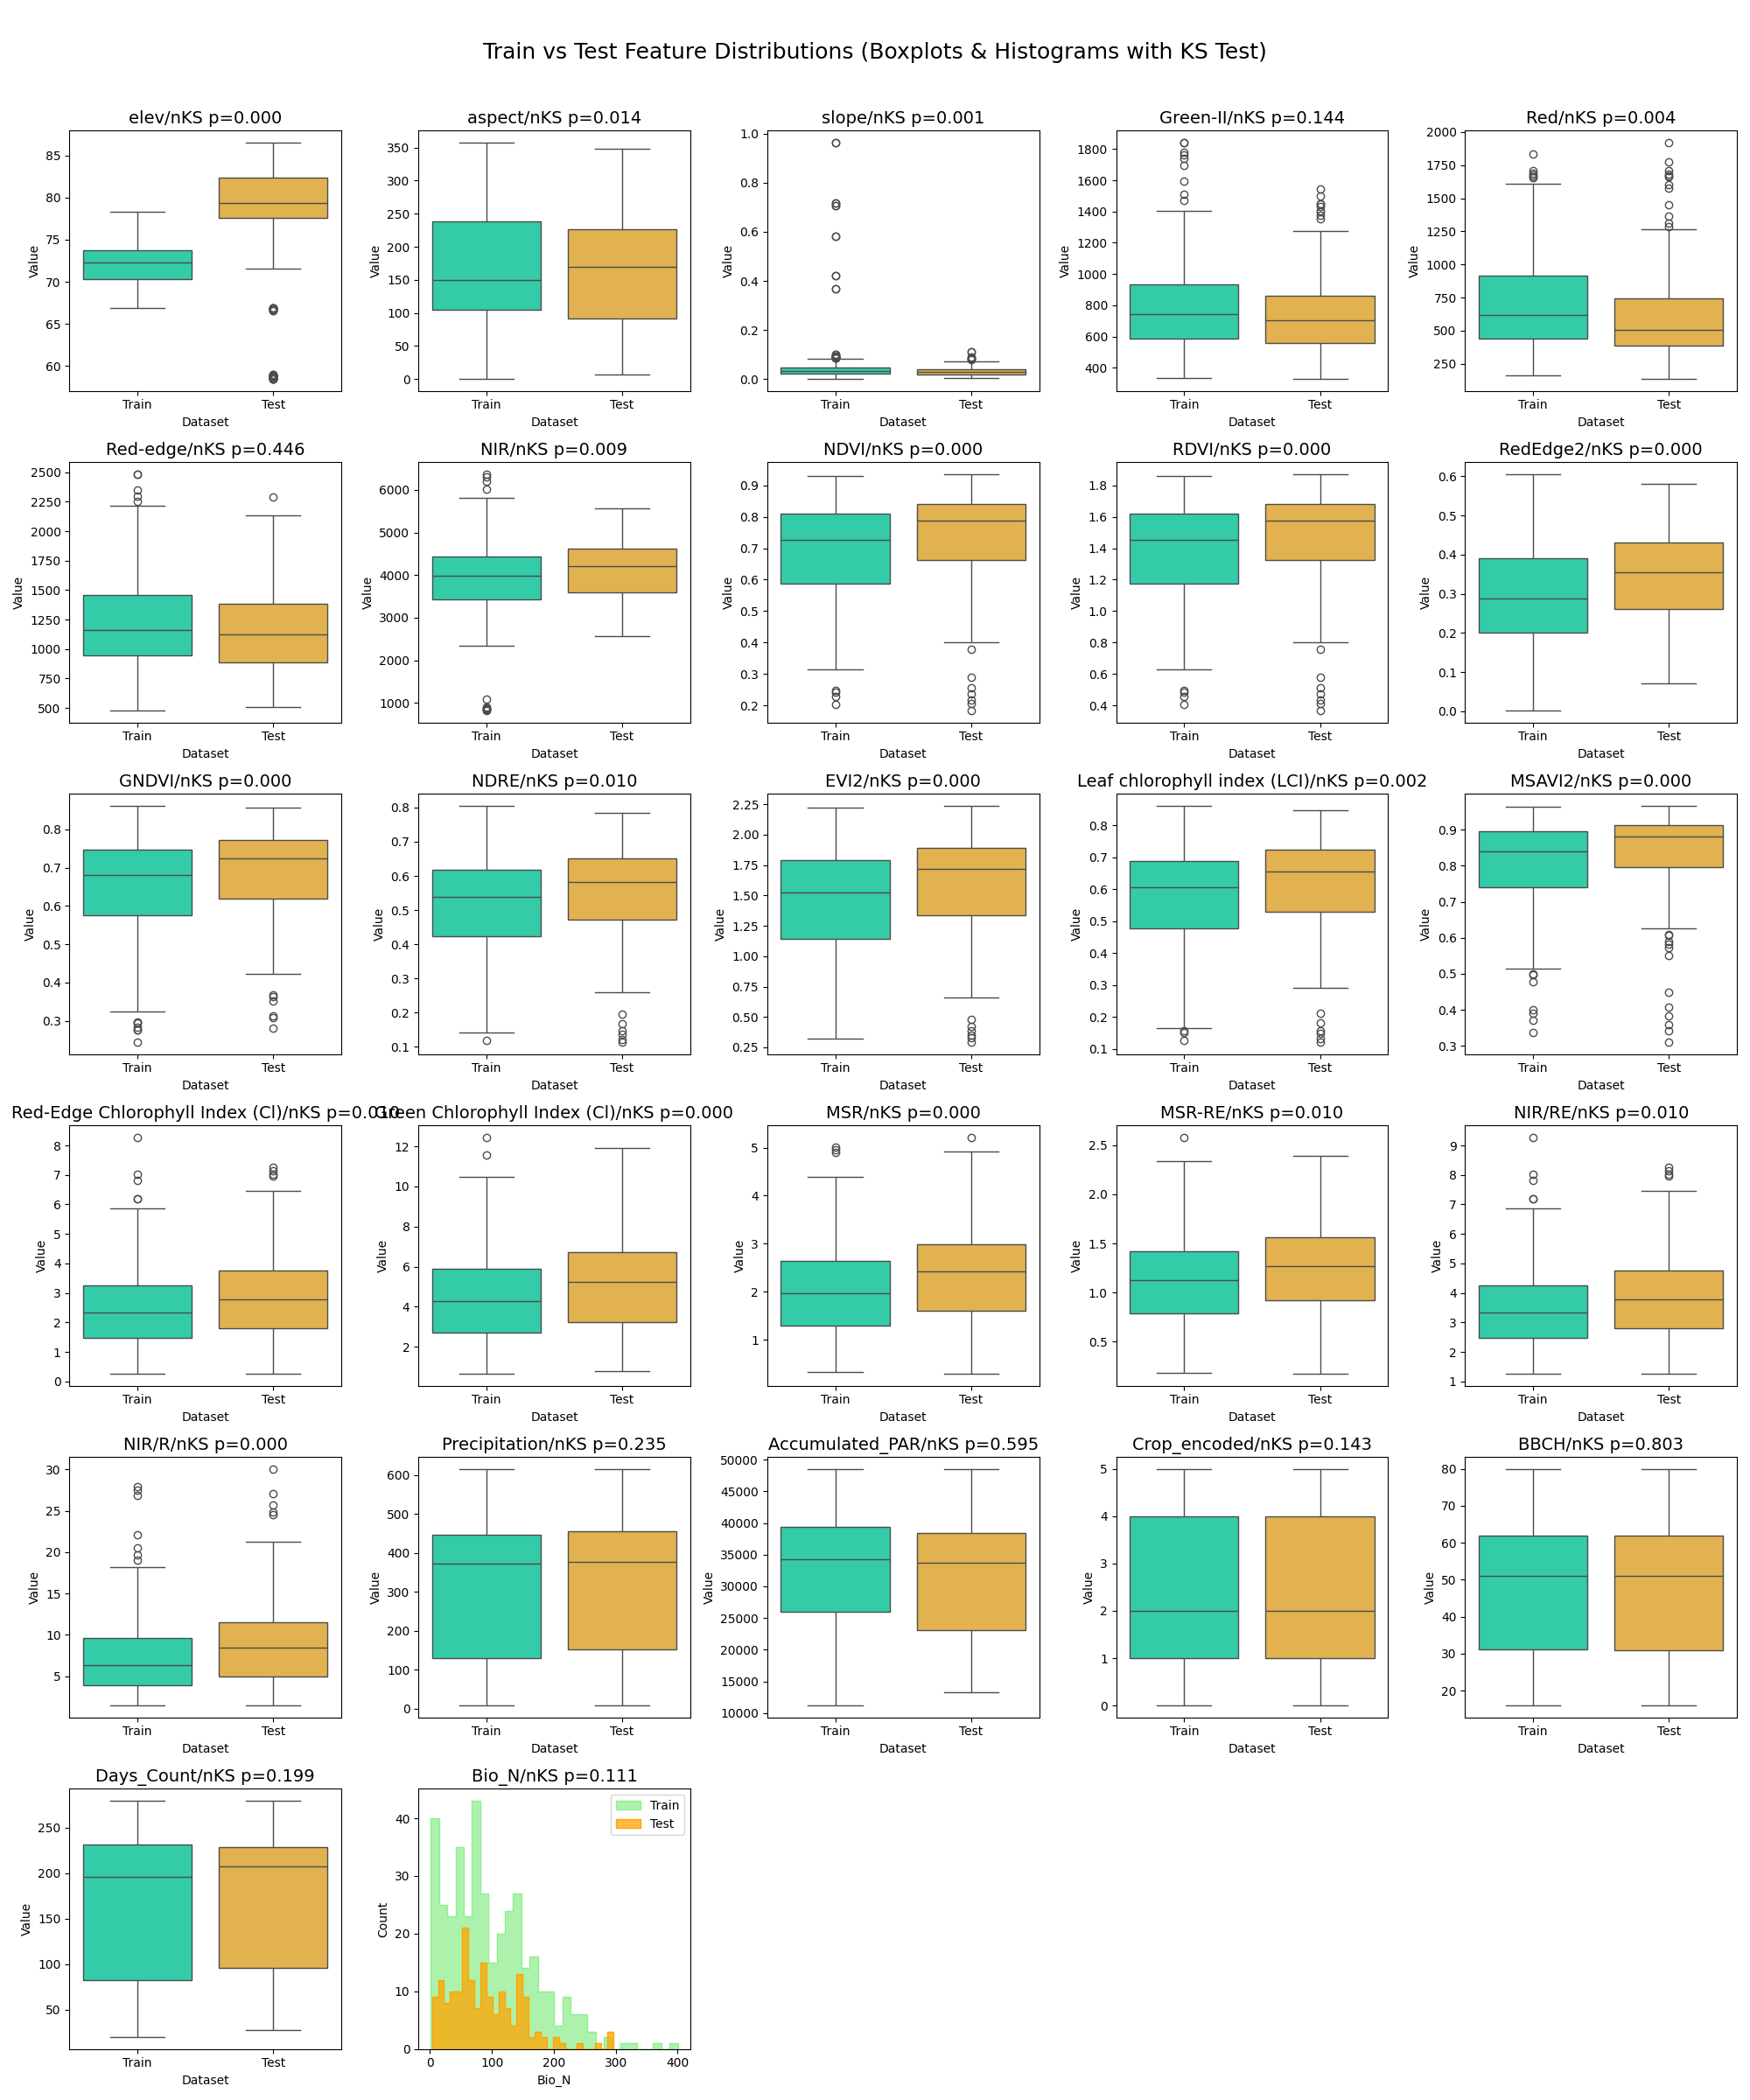

✅ KS test results saved to 'KS_test_results_train_vs_test.xlsx'


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ks_2samp

# List of features to be plotted as histograms
hist_features = ['Bio_N', 'Bio_Dm']

# Initialize a list to store KS test results
ks_results = []

# All features to analyze
features = predictor_columns + [target_column]

# Layout settings for subplots
import math
n_features = len(features)
n_cols = 5
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

# Loop over features
for idx, feature in enumerate(features):
    # KS test between training and test distributions
    ks_stat, p_value = ks_2samp(train_df[feature], test_df[feature])
    ks_results.append({'Feature': feature, 'KS_statistic': ks_stat, 'p_value': p_value})

    ax = axes[idx]
    
    if feature in hist_features:
        # Plot histogram with KDE
        sns.histplot(train_df[feature], label="Train", color='lightgreen', stat='count', ax=ax, element="step", bins=30)
        sns.histplot(test_df[feature], label="Test", color='orange', stat='count', ax=ax, element="step", bins=30)
        ax.set_xlabel(feature)
        ax.set_ylabel("Count")
        ax.legend()
    else:
        # Boxplot
        combined = pd.DataFrame({
            'Value': pd.concat([train_df[feature], test_df[feature]], ignore_index=True),
            'Dataset': ['Train'] * len(train_df) + ['Test'] * len(test_df)
        })
        sns.boxplot(data=combined, x='Dataset', y='Value', palette="turbo", ax=ax)

    ax.set_title(f'{feature}/nKS p={p_value:.3f}', fontsize=14)
    ax.tick_params(axis='x', labelrotation=0)

# Remove unused axes
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Final layout
plt.suptitle("Train vs Test Feature Distributions (Boxplots & Histograms with KS Test)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Save KS test results
ks_df = pd.DataFrame(ks_results)
ks_df.to_excel("KS_test_results_train_vs_test.xlsx", index=False)
print("✅ KS test results saved to 'KS_test_results_train_vs_test.xlsx'")



# Setting hyperparameters for the RF model

In [18]:
# Hyperparameter Grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'bootstrap': [True]
}


# K-fold cross validation for training

In [19]:
# KFold Cross-Validation + RandomizedSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=50)
best_params_list = []
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"/n🔁 Fold {fold + 1}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf = RandomForestRegressor(random_state=50)
    grid = RandomizedSearchCV(rf, param_dist,n_iter=900, cv=5, scoring='r2', n_jobs=-1, verbose=1)
    grid.fit(X_tr, y_tr)

    best_model = grid.best_estimator_
    val_preds = best_model.predict(X_val)
    r2 = r2_score(y_val, val_preds)
    print(f"Best Params: {grid.best_params_}, R2: {r2:.3f}")

    best_params_list.append(grid.best_params_)
    cv_scores.append(r2)


/n🔁 Fold 1
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}, R2: 0.689
/n🔁 Fold 2
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}, R2: 0.740
/n🔁 Fold 3
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}, R2: 0.633
/n🔁 Fold 4
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}, R2: 0.809
/n🔁 Fold 5
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Params: 

# Most Frequent Params Across Folds

In [20]:

from collections import Counter
most_common_params = Counter([frozenset(p.items()) for p in best_params_list]).most_common(1)[0][0]
final_params = dict(most_common_params)
print(f"/n✅ Most Common Hyperparameters: {final_params}")


/n✅ Most Common Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 6, 'max_features': 'sqrt'}


# Model performence on test data

In [21]:

final_model = RandomForestRegressor(**final_params, random_state=42)
final_model.fit(X_train, y_train)
test_preds = final_model.predict(X_test)

print("/n📊 Test Set Performance:")
print("R²:", r2_score(y_test, test_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("MAE:", mean_absolute_error(y_test, test_preds))

# Per-Crop Performance
test_df = test_df.assign(Predicted=test_preds)
crop_scores = test_df.groupby("Crop").apply(
    lambda d: pd.Series({
        "R2": r2_score(d[target_column], d["Predicted"]),
        "RMSE": np.sqrt(mean_squared_error(d[target_column], d["Predicted"])),
        "MAE": mean_absolute_error(d[target_column], d["Predicted"])
    })
).round(3)

print("/n📊 Per-Crop Performance:")
print(crop_scores)

# ✅ Save the trained model
import joblib
joblib.dump(final_model, "final_rf_model_Bio_N.pkl")
print("✅ Final Random Forest model saved as 'final_rf_model.pkl'")

/n📊 Test Set Performance:
R²: 0.6654827845145792
RMSE: 33.63630327232615
MAE: 23.77906821730881
/n📊 Per-Crop Performance:
              R2    RMSE     MAE
Crop                            
Barley     0.537  30.167  24.785
Maize      0.333  25.524  20.028
Rapeseed   0.614  42.695  30.245
Rye        0.707  25.239  19.094
Sunflower  0.469  47.528  30.558
Wheat      0.809  20.136  15.993
✅ Final Random Forest model saved as 'final_rf_model.pkl'


# SHAP ANALYSIS for feature importance on (Test Set)

/n🔍 Running SHAP analysis...


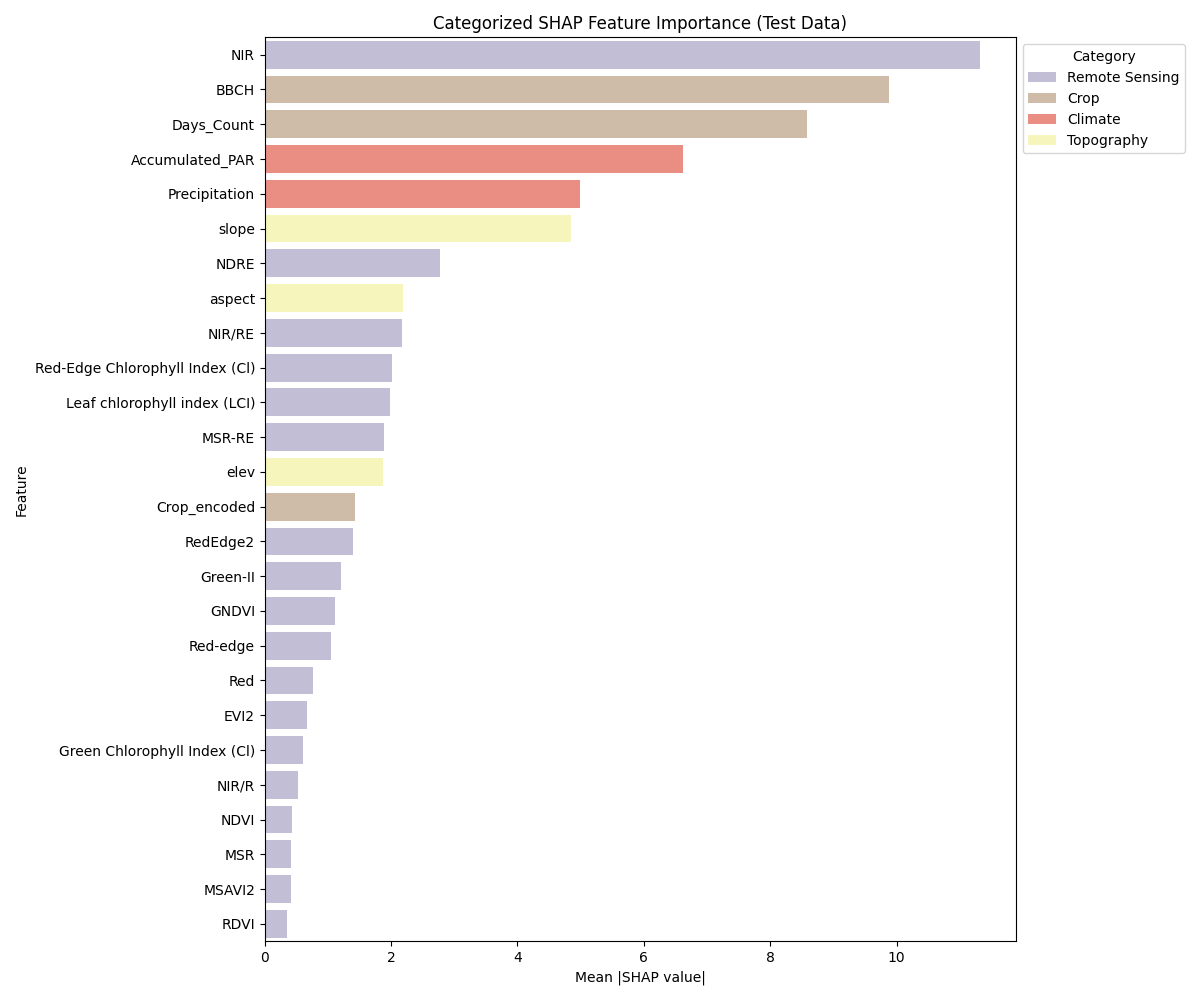

/n🎯 Creating SHAP beeswarm plot...


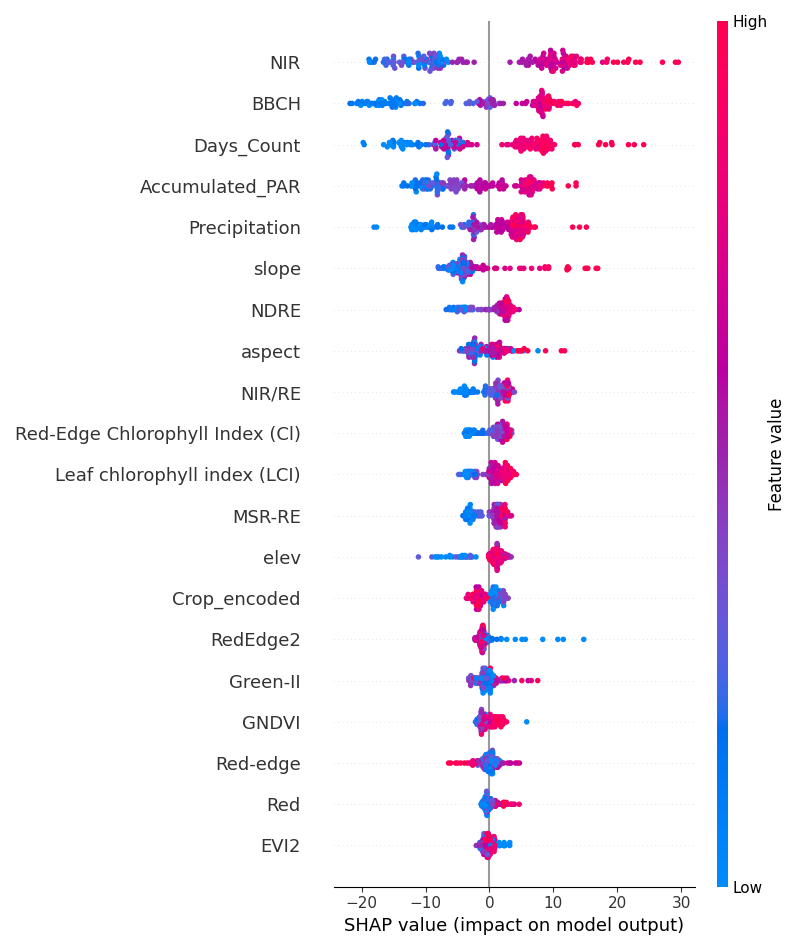

In [22]:

# ========================
print("/n🔍 Running SHAP analysis...")

explainer = shap.TreeExplainer(final_model)
shap_values_test = explainer.shap_values(X_test)

# Handle SHAP output format
if isinstance(shap_values_test, list):
    shap_values_test = shap_values_test[0]

# Define feature categories
feature_categories = {
    'Soil moisture': 'Soil', 'Sand': 'Soil', 'Silt': 'Soil', 'Clay': 'Soil',
    'elev': 'Topography', 'aspect': 'Topography', 'slope': 'Topography',
    'Green-II': 'Remote Sensing', 'Red': 'Remote Sensing', 'Red-edge': 'Remote Sensing', 'NIR': 'Remote Sensing',
    'NDVI': 'Remote Sensing', 'RDVI': 'Remote Sensing', 'RedEdge2': 'Remote Sensing',
    'GNDVI': 'Remote Sensing', 'NDRE': 'Remote Sensing', 'EVI2': 'Remote Sensing',
    'Leaf chlorophyll index (LCI)': 'Remote Sensing', 'MSAVI2': 'Remote Sensing',
    'Red-Edge Chlorophyll Index (Cl)': 'Remote Sensing', 'Green Chlorophyll Index (Cl)': 'Remote Sensing',
    'MSR': 'Remote Sensing', 'MSR-RE': 'Remote Sensing', 'NIR/RE': 'Remote Sensing', 'NIR/R': 'Remote Sensing',
    'Precipitation': 'Climate', 'Accumulated_PAR': 'Climate',
    'Crop_encoded': 'Crop', 'Days_Count': 'Crop', 'BBCH': 'Crop'
}

# Mean Absolute SHAP
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Abs_SHAP': np.abs(shap_values_test).mean(axis=0)
})
shap_importance['Category'] = shap_importance['Feature'].map(feature_categories)
shap_importance = shap_importance.sort_values('Mean_Abs_SHAP', ascending=False)

# Color palette
palette = {
    'Soil': '#8dd3c7', 'Topography': '#ffffb3', 'Remote Sensing': '#bebada',
    'Climate': '#fb8072', 'Crop': '#d4bba2'
}

# Plot Categorized Barplot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=shap_importance,
    y='Feature',
    x='Mean_Abs_SHAP',
    hue='Category',
    palette=palette,
    dodge=False
)
plt.title("Categorized SHAP Feature Importance (Test Data)")
plt.xlabel("Mean |SHAP value|")
plt.ylabel("Feature")
plt.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# SHAP Beeswarm Plot
print("/n🎯 Creating SHAP beeswarm plot...")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_test, X_test, plot_type="dot", show=True)


# SCATTER PLOTS

/n📈 Creating scatter plots...


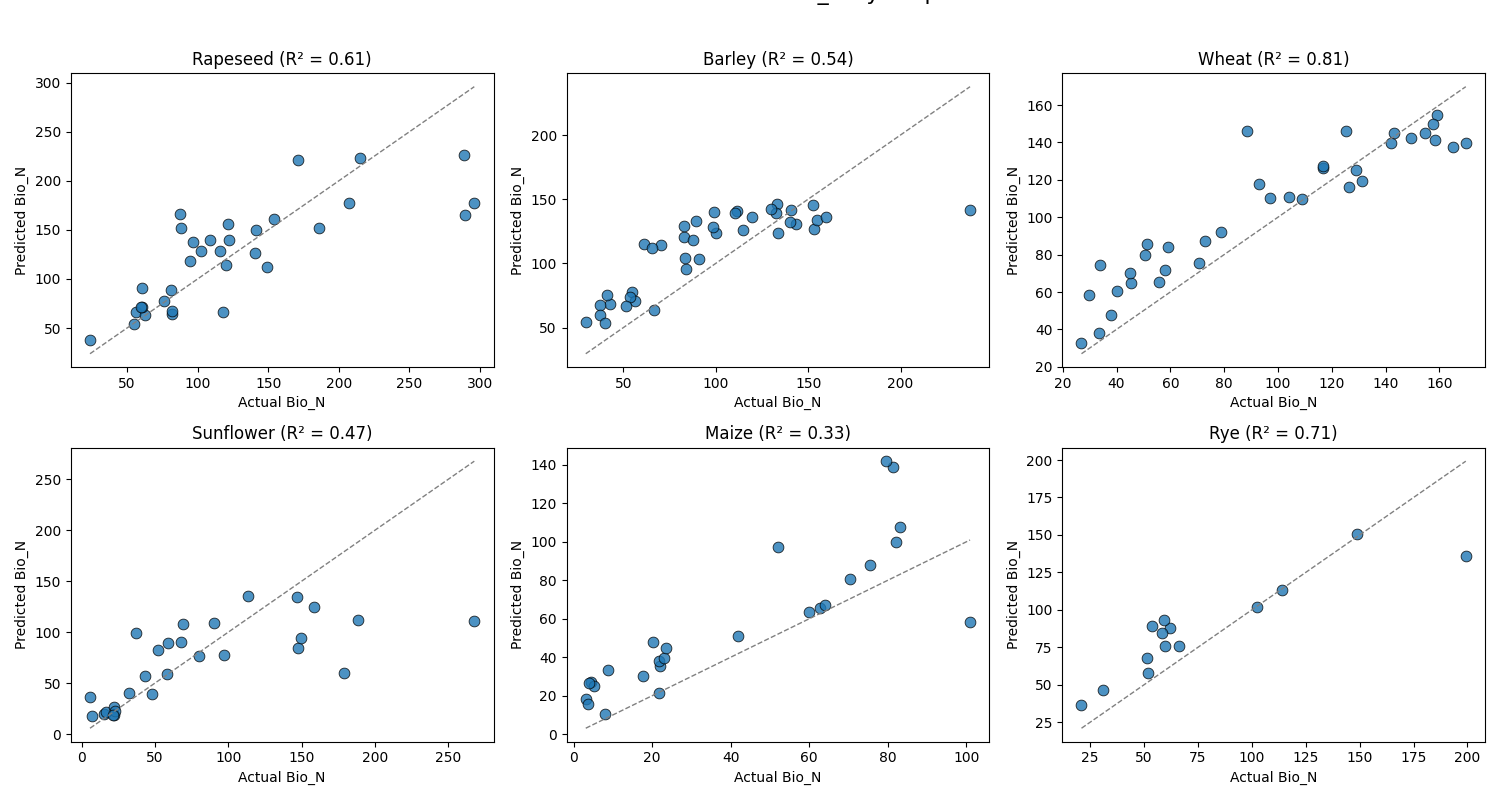

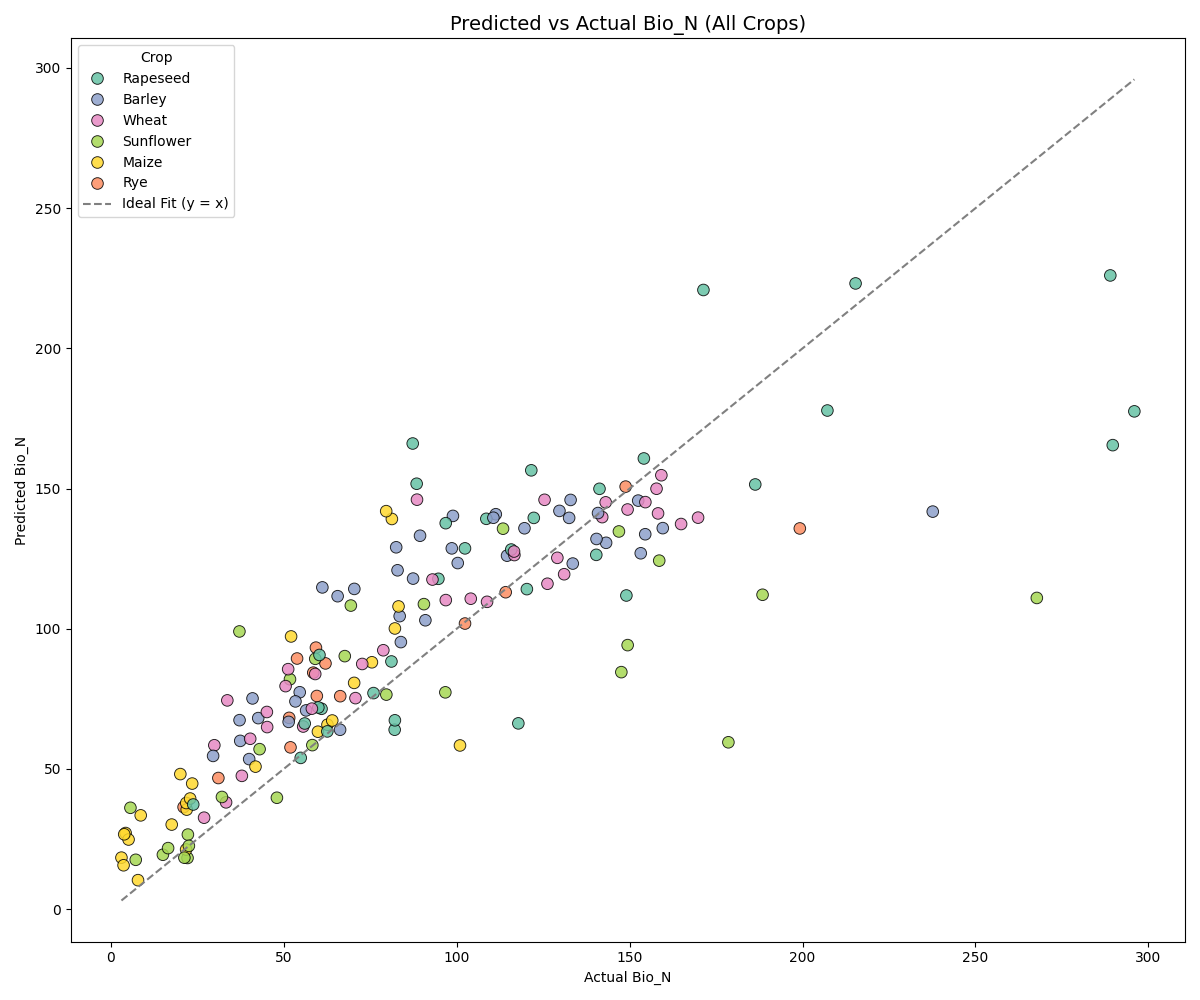

In [23]:

# ========================
print("/n📈 Creating scatter plots...")

# Prepare summary dataframe
summary_df = test_df[['Crop', 'Bio_N', 'Predicted']].rename(columns={'Bio_N': 'Actual'})

# Per-Crop Scatter Plots
unique_crops = summary_df['Crop'].unique()
n_crops = len(unique_crops)
n_cols = 3
n_rows = int(np.ceil(n_crops / n_cols))

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i, crop in enumerate(unique_crops):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    crop_data = summary_df[summary_df["Crop"] == crop]
    sns.scatterplot(data=crop_data, x="Actual", y="Predicted", s=60, edgecolor='k', alpha=0.8, ax=ax)
    ax.plot([crop_data["Actual"].min(), crop_data["Actual"].max()],
            [crop_data["Actual"].min(), crop_data["Actual"].max()],
            color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{crop} (R² = {r2_score(crop_data['Actual'], crop_data['Predicted']):.2f})")
    ax.set_xlabel("Actual Bio_N")
    ax.set_ylabel("Predicted Bio_N")
plt.suptitle("Actual vs Predicted Bio_N by Crop", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Overall Scatter Plot
# Custom color palette for consistent crop colors
custom_palette = {
    'Rapeseed': '#66c2a5',
    'Rye': '#fc8d62',
    'Barley': '#8da0cb',
    'Wheat': '#e78ac3',
    'Sunflower': '#a6d854',
    'Maize': '#ffd92f'
}

# Overall Scatter Plot with custom colors
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=summary_df,
    x="Actual",
    y="Predicted",
    hue="Crop",
    palette=custom_palette,
    s=70,
    edgecolor='k',
    alpha=0.85
)

# Diagonal line
min_val = min(summary_df["Actual"].min(), summary_df["Predicted"].min())
max_val = max(summary_df["Actual"].max(), summary_df["Predicted"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1.5, label="Ideal Fit (y = x)")

plt.title("Predicted vs Actual Bio_N (All Crops)", fontsize=14)
plt.xlabel("Actual Bio_N")
plt.ylabel("Predicted Bio_N")
plt.legend(title="Crop", bbox_to_anchor=(0, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()


# BOOTSTRAPPING

/n🎲 Running bootstrapping for model stability...


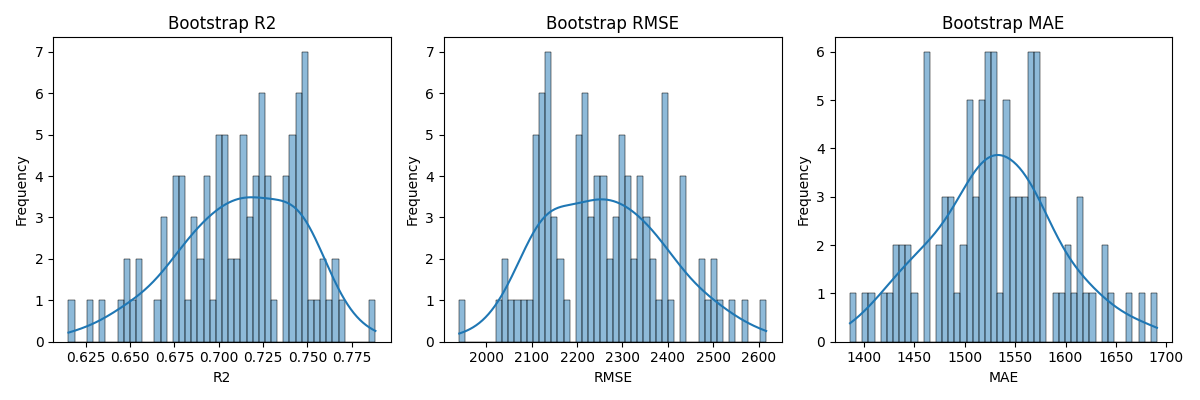

/n📈 Bootstrap Summary Statistics:
            R2      RMSE       MAE
count  100.000   100.000   100.000
mean     0.712  2261.148  1530.035
std      0.035   135.273    62.229
min      0.615  1940.481  1386.065
25%      0.688  2142.507  1486.993
50%      0.715  2251.252  1526.983
75%      0.742  2356.189  1568.781
max      0.788  2616.470  1690.688


In [15]:

# ========================
print("/n🎲 Running bootstrapping for model stability...")

from sklearn.utils import resample

bootstrap_results = []
n_iterations = 100

for i in range(n_iterations):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=42 + i)

    model = RandomForestRegressor(**final_params, random_state=42 + i)
    model.fit(X_boot, y_boot)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    bootstrap_results.append({'R2': r2, 'RMSE': rmse, 'MAE': mae})

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

# Plot Bootstrap Distributions
plt.figure(figsize=(12, 4))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(bootstrap_df[metric], kde=True, bins=50)
    plt.title(f"Bootstrap {metric}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Summary stats
print("/n📈 Bootstrap Summary Statistics:")
print(bootstrap_df.describe().round(3))